<a href="https://colab.research.google.com/github/arafat-hasan/waste-sorter/blob/master/two-classes/waste_sorter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!data

/bin/bash: data: command not found


In [2]:
!pip install torchviz
!pip install livelossplot

     |████████████████████████████████| 51kB 5.7MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3523 sha256=87b32b2f79a20002b9272db7ba45ea31f45f5c8e8b3306fd1969f58cc1db69c2
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


#### modeling pipeline:

1. Download and extract the images
2. Organize the images into different folders
3. Train model
4. Make and evaluate test predictions
5. Next steps

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [4]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Extract data

In [5]:
!wget https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip

--2020-06-14 13:37:39--  https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip
Resolving github.com (github.com)... 13.229.188.59
Connecting to github.com (github.com)|13.229.188.59|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip [following]
--2020-06-14 13:37:39--  https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42834870 (41M) [application/zip]
Saving to: ‘dataset-resized.zip’

dataset-resized.zip 100%[===================>]  40.85M   178MB/s    in 0.2s    

2020-06-14 13:37:43 (178 MB/s) - ‘dataset-resized.zip’ saved [42834870/42834870]



First, we need to extract the contents of "dataset-resized.zip".

In [6]:
!ls -la
!pwd

total 41848
drwxr-xr-x 1 root root     4096 Jun 14 13:37 .
drwxr-xr-x 1 root root     4096 Jun 14 13:35 ..
drwxr-xr-x 1 root root     4096 Jun 10 16:28 .config
-rw-r--r-- 1 root root 42834870 Jun 14 13:37 dataset-resized.zip
drwxr-xr-x 1 root root     4096 Jun 10 16:28 sample_data
/content


In [0]:
files = zf.ZipFile("dataset-resized.zip",'r')
files.extractall()
files.close()

Once unzipped, the dataset-resized folder has six subfolders:

&nbsp;&nbsp;&nbsp;&nbsp; /dataset-resized <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /cardboard <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /glass <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /metal <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /paper <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /plastic <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /trash <br>


In [8]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['.DS_Store', 'plastic', 'trash', 'paper', 'cardboard', 'metal', 'glass']

Now, We will create two directory in side dataset-resized named `digestible` and `indigestible`. After that, we have to move all images from `trash` directory to `digestible` directory and all images from rest other five directories to `indigestible` directory. And then we have to delete the empty six directories.

&nbsp;&nbsp;&nbsp;&nbsp; /dataset-resized <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /digestible <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /indigestible <br>



In [9]:
!rm dataset-resized.zip
!ls -la /content
!mkdir /content/dataset-resized/digestible/ /content/dataset-resized/indigestible/
!ls -la /content/dataset-resized/

total 24
drwxr-xr-x 1 root root 4096 Jun 14 13:38 .
drwxr-xr-x 1 root root 4096 Jun 14 13:35 ..
drwxr-xr-x 1 root root 4096 Jun 10 16:28 .config
drwxr-xr-x 8 root root 4096 Jun 14 13:38 dataset-resized
drwxr-xr-x 3 root root 4096 Jun 14 13:38 __MACOSX
drwxr-xr-x 1 root root 4096 Jun 10 16:28 sample_data
total 124
drwxr-xr-x 10 root root  4096 Jun 14 13:38 .
drwxr-xr-x  1 root root  4096 Jun 14 13:38 ..
drwxr-xr-x  2 root root 20480 Jun 14 13:38 cardboard
drwxr-xr-x  2 root root  4096 Jun 14 13:38 digestible
-rw-r--r--  1 root root  6148 Jun 14 13:38 .DS_Store
drwxr-xr-x  2 root root 20480 Jun 14 13:38 glass
drwxr-xr-x  2 root root  4096 Jun 14 13:38 indigestible
drwxr-xr-x  2 root root 16384 Jun 14 13:38 metal
drwxr-xr-x  2 root root 20480 Jun 14 13:38 paper
drwxr-xr-x  2 root root 20480 Jun 14 13:38 plastic
drwxr-xr-x  2 root root  4096 Jun 14 13:38 trash


In [0]:
!mv /content/dataset-resized/cardboard/* /content/dataset-resized/indigestible/
!mv /content/dataset-resized/glass/* /content/dataset-resized/indigestible/
!mv /content/dataset-resized/metal/* /content/dataset-resized/indigestible/
!mv /content/dataset-resized/paper/* /content/dataset-resized/indigestible/
!mv /content/dataset-resized/plastic/* /content/dataset-resized/indigestible/
!mv /content/dataset-resized/trash/* /content/dataset-resized/digestible/

!rm -r /content/dataset-resized/cardboard/
!rm -r /content/dataset-resized/glass/
!rm -r /content/dataset-resized/metal/
!rm -r /content/dataset-resized/paper/
!rm -r /content/dataset-resized/plastic/
!rm -r /content/dataset-resized/trash/

In [11]:
!ls -la /content/dataset-resized/

total 96
drwxr-xr-x 4 root root  4096 Jun 14 13:39 .
drwxr-xr-x 1 root root  4096 Jun 14 13:38 ..
drwxr-xr-x 2 root root  4096 Jun 14 13:38 digestible
-rw-r--r-- 1 root root  6148 Jun 14 13:38 .DS_Store
drwxr-xr-x 2 root root 77824 Jun 14 13:38 indigestible


In [0]:
!ls -v /content/dataset-resized/digestible/ | cat -n | while read n f; do mv -n "/content/dataset-resized/digestible/$f" "/content/dataset-resized/digestible/digestible$n.jpg"; done 

In [0]:
!ls -v /content/dataset-resized/indigestible/ | cat -n | while read n f; do mv -n "/content/dataset-resized/indigestible/$f" "/content/dataset-resized/indigestible/indigestible$n.jpg"; done 

## 2. Organize images into different folders



In [0]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.8*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

Next, I'm going to create a bunch of destination folders according to the ImageNet directory convention. It'll look like this:

/data <br>
&nbsp;&nbsp;&nbsp;&nbsp; /train <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /digestible <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /indigestible <br>
&nbsp;&nbsp;&nbsp;&nbsp; /valid <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /digestible <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /indigestible <br>
&nbsp;&nbsp;&nbsp;&nbsp;/test <br>

Each image file is just the material name and a number (i.e. digestible1.jpg)

Again, this is just housekeeping to organize my files.

In [0]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['digestible','indigestible']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('/content/dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [16]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [0]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

In [18]:
data

ImageDataBunch;

Train: LabelList (2021 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
indigestible,indigestible,indigestible,indigestible,indigestible
Path: /content/data;

Valid: LabelList (253 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
indigestible,indigestible,indigestible,indigestible,indigestible
Path: /content/data;

Test: LabelList (253 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data

In [19]:
print(data.classes)

['digestible', 'indigestible']


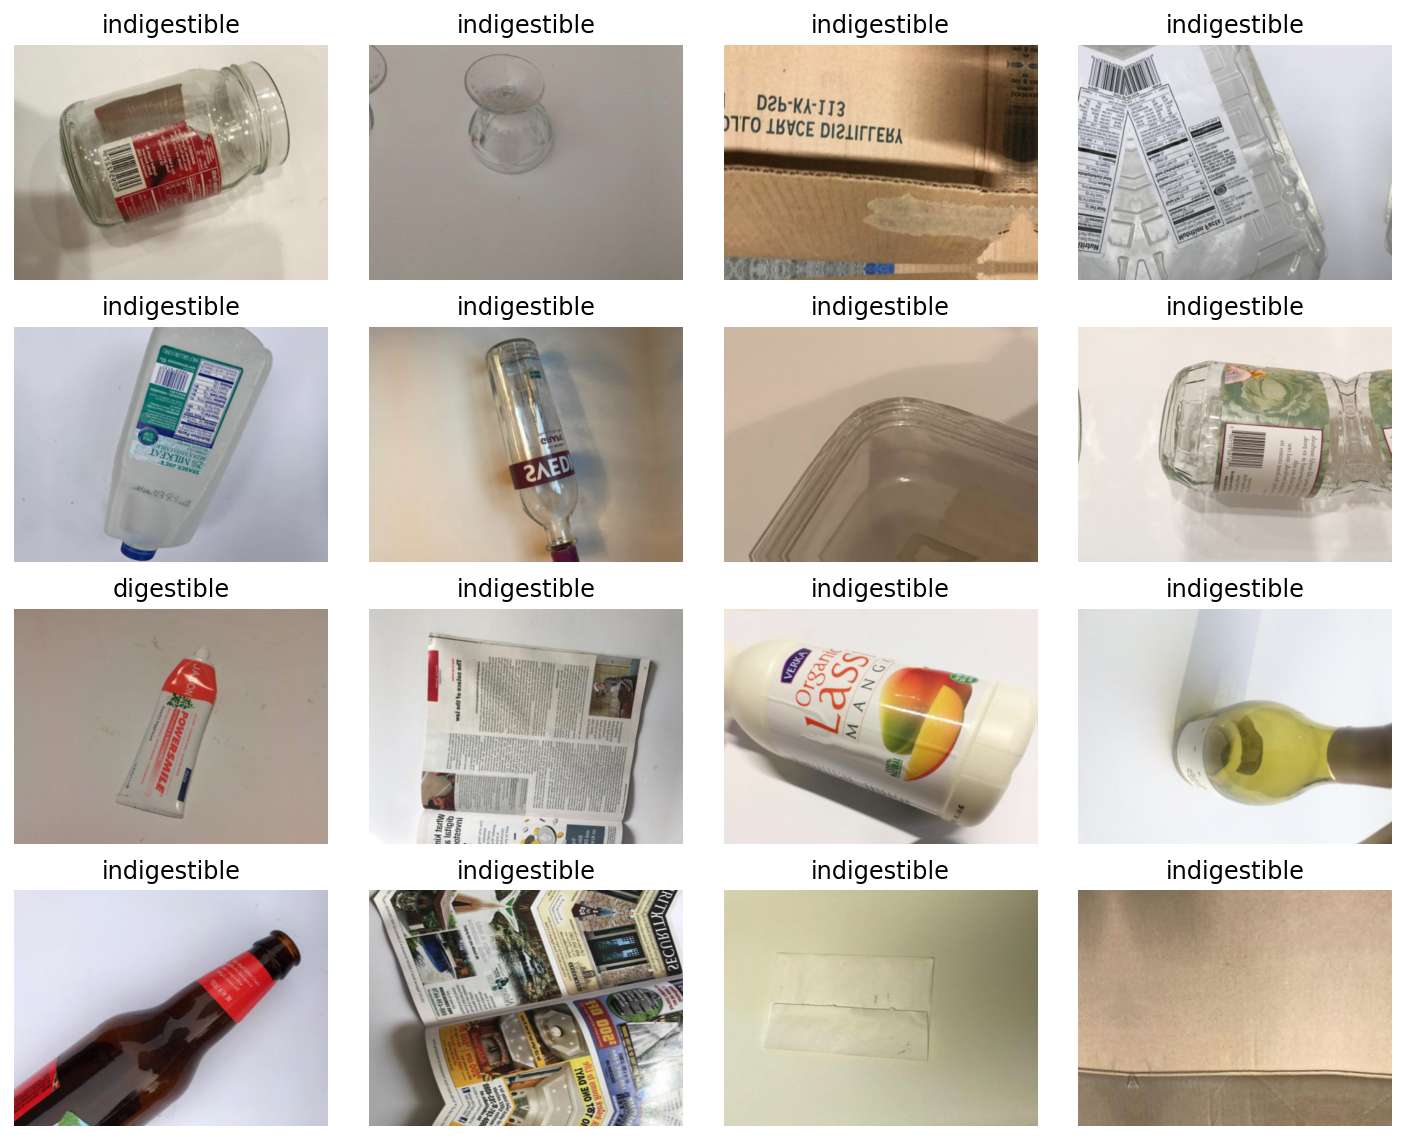

In [20]:
data.show_batch(rows=4,figsize=(10,8))

## 3. Model training

In [21]:
learn = cnn_learner(data,models.resnet34,metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [22]:
print(learn)

Learner(data=ImageDataBunch;

Train: LabelList (2021 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
indigestible,indigestible,indigestible,indigestible,indigestible
Path: /content/data;

Valid: LabelList (253 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
indigestible,indigestible,indigestible,indigestible,indigestible
Path: /content/data;

Test: LabelList (253 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1,

In [23]:
from torchviz import make_dot, make_dot_from_trace
from torch.autograd import Variable

inputs = torch.randn(1,3,224,224)
resnet34 = models.resnet34()
y = resnet34(Variable(inputs))
# print(y)

dot = make_dot(y)
dot.format = 'pdf'
dot.render("struct")

'struct.pdf'

### Finding a learning rate



In [0]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = True) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


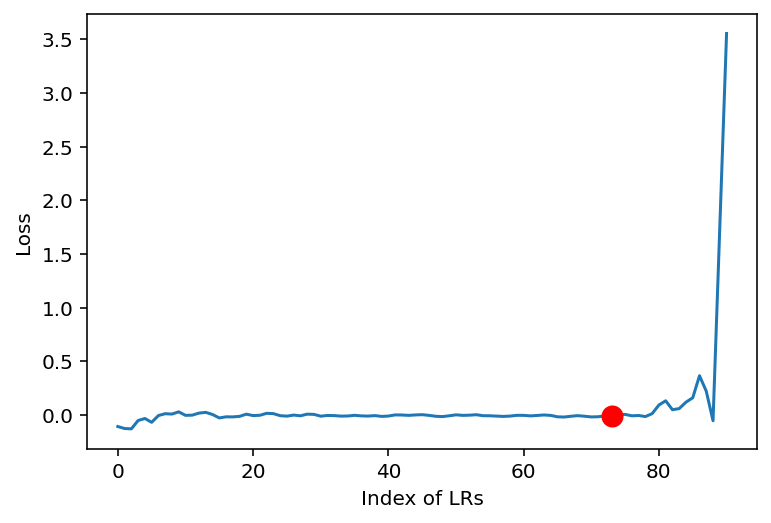

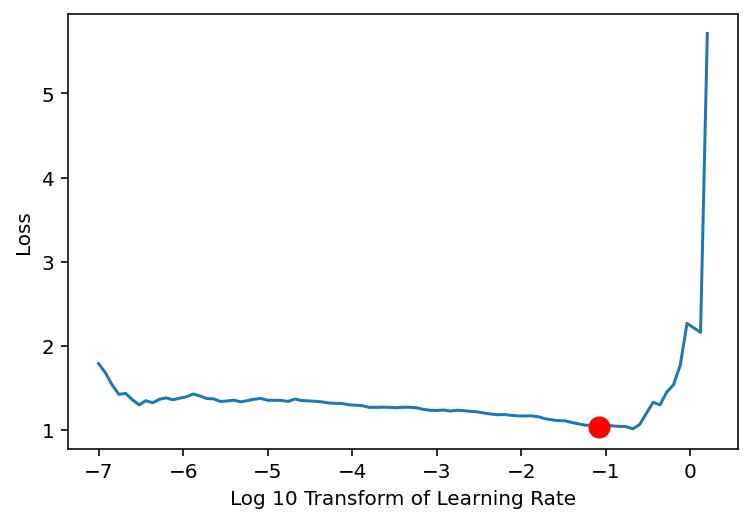

In [25]:
sugesstion=find_appropriate_lr(learn)

learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()


### Training

In [26]:
learn.fit_one_cycle(34,max_lr=sugesstion)

epoch,train_loss,valid_loss,error_rate,time
0,0.326537,0.077153,0.039526,00:59
1,0.297165,0.164317,0.051383,01:00
2,0.394602,0.434286,0.059289,01:00
3,0.416203,0.373122,0.055336,01:00
4,0.435803,0.207922,0.055336,01:00
5,0.645944,0.633643,0.055336,01:01
6,0.484600,0.597681,0.363636,01:01
7,0.638865,0.599070,0.114625,01:00
8,0.844199,0.674752,0.067194,01:00
9,0.669695,0.536455,0.055336,01:01


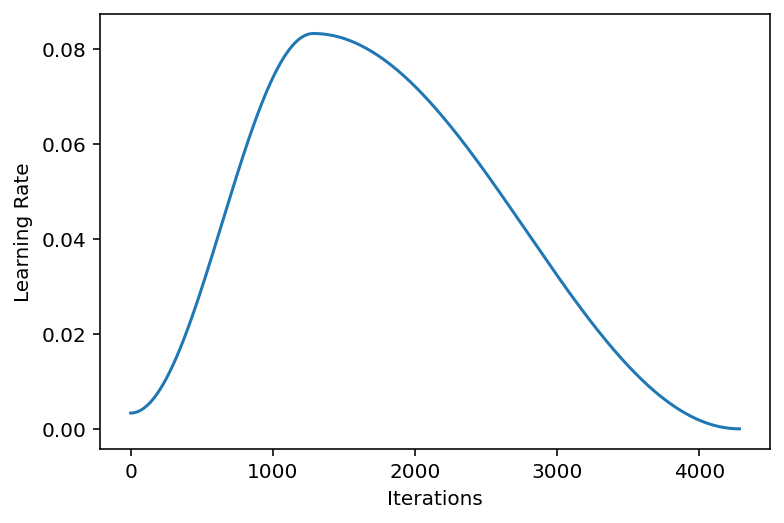

In [27]:
learn.recorder.plot_lr()

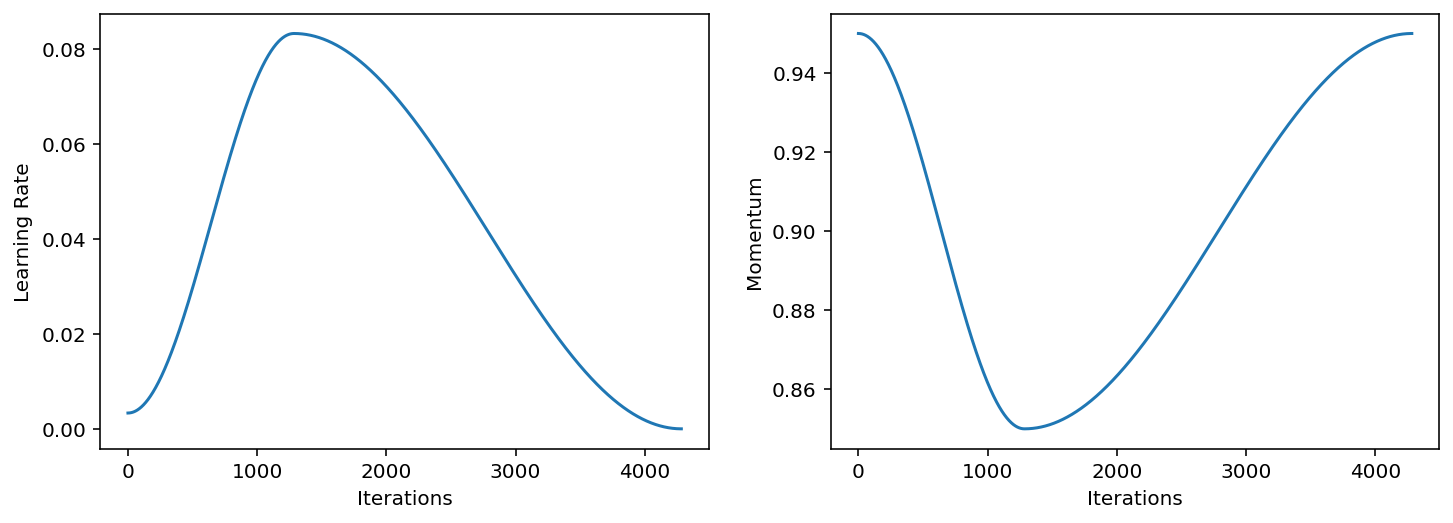

In [28]:
learn.recorder.plot_lr(show_moms=True)

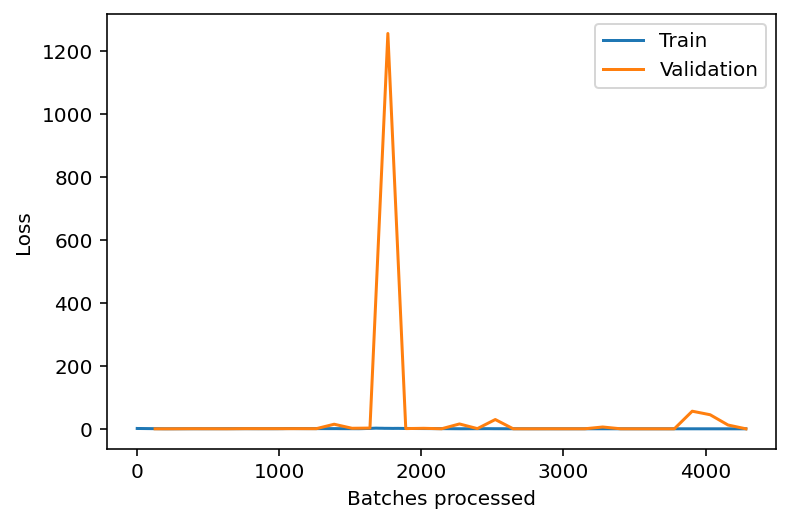

In [29]:
learn.recorder.plot_losses()

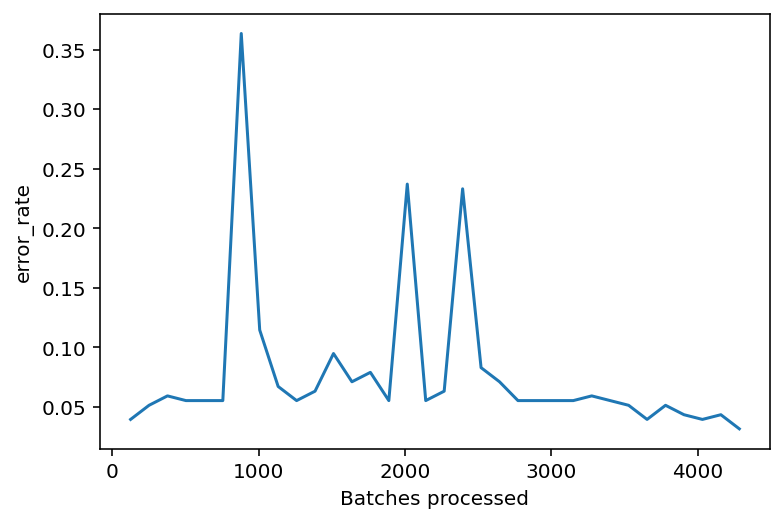

In [30]:
learn.recorder.plot_metrics()

In [31]:
learn.save("trained_model", return_path=True)

PosixPath('/content/data/models/trained_model.pth')

In [0]:
!cp /content/data/models/trained_model.pth /content/

### VIsualizing most incorrect images

In [33]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

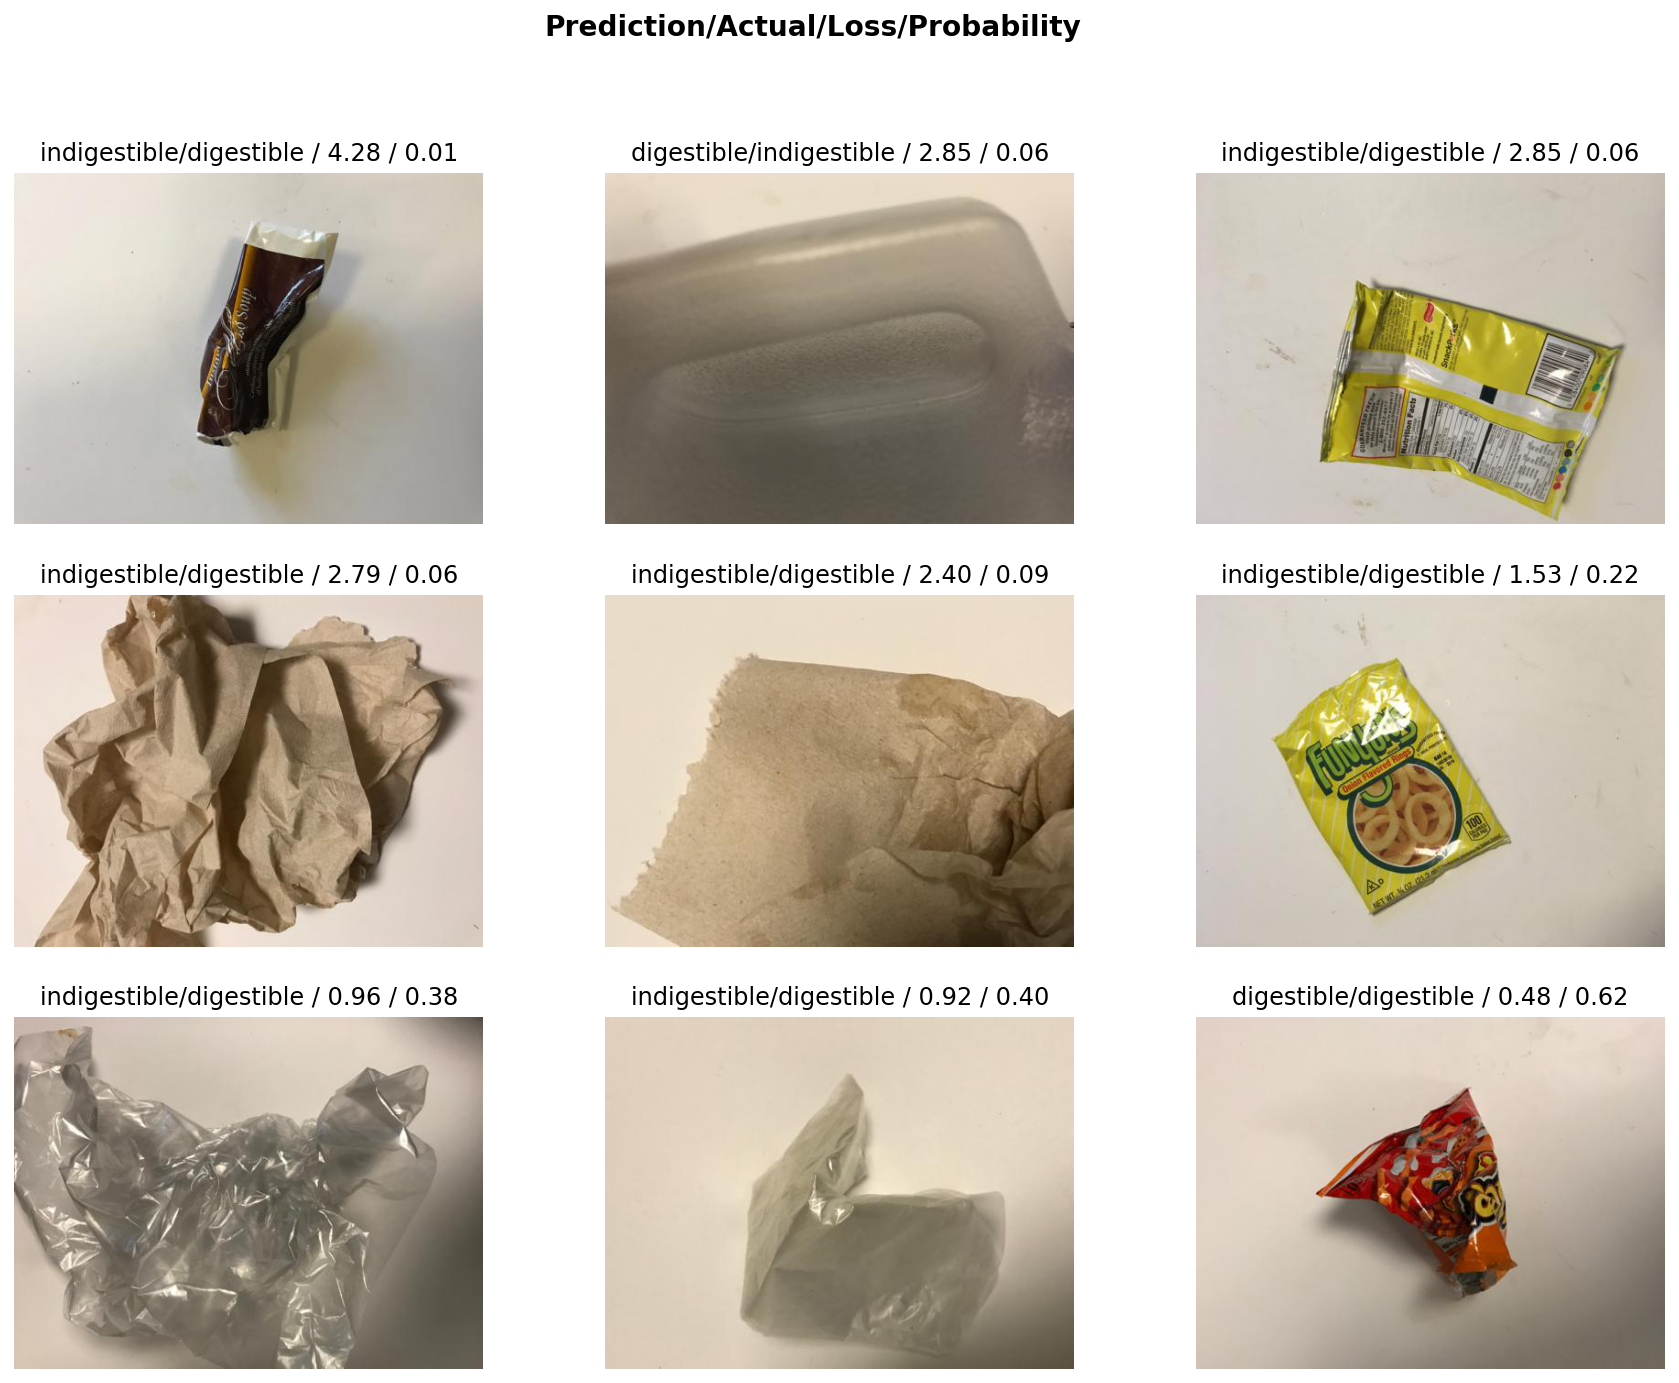

In [34]:
interp.plot_top_losses(9, figsize=(15,11))

The images here that the recycler performed poorly on were actually degraded. It looks the photos received too much exposure or something so this actually isn't a fault with the model!

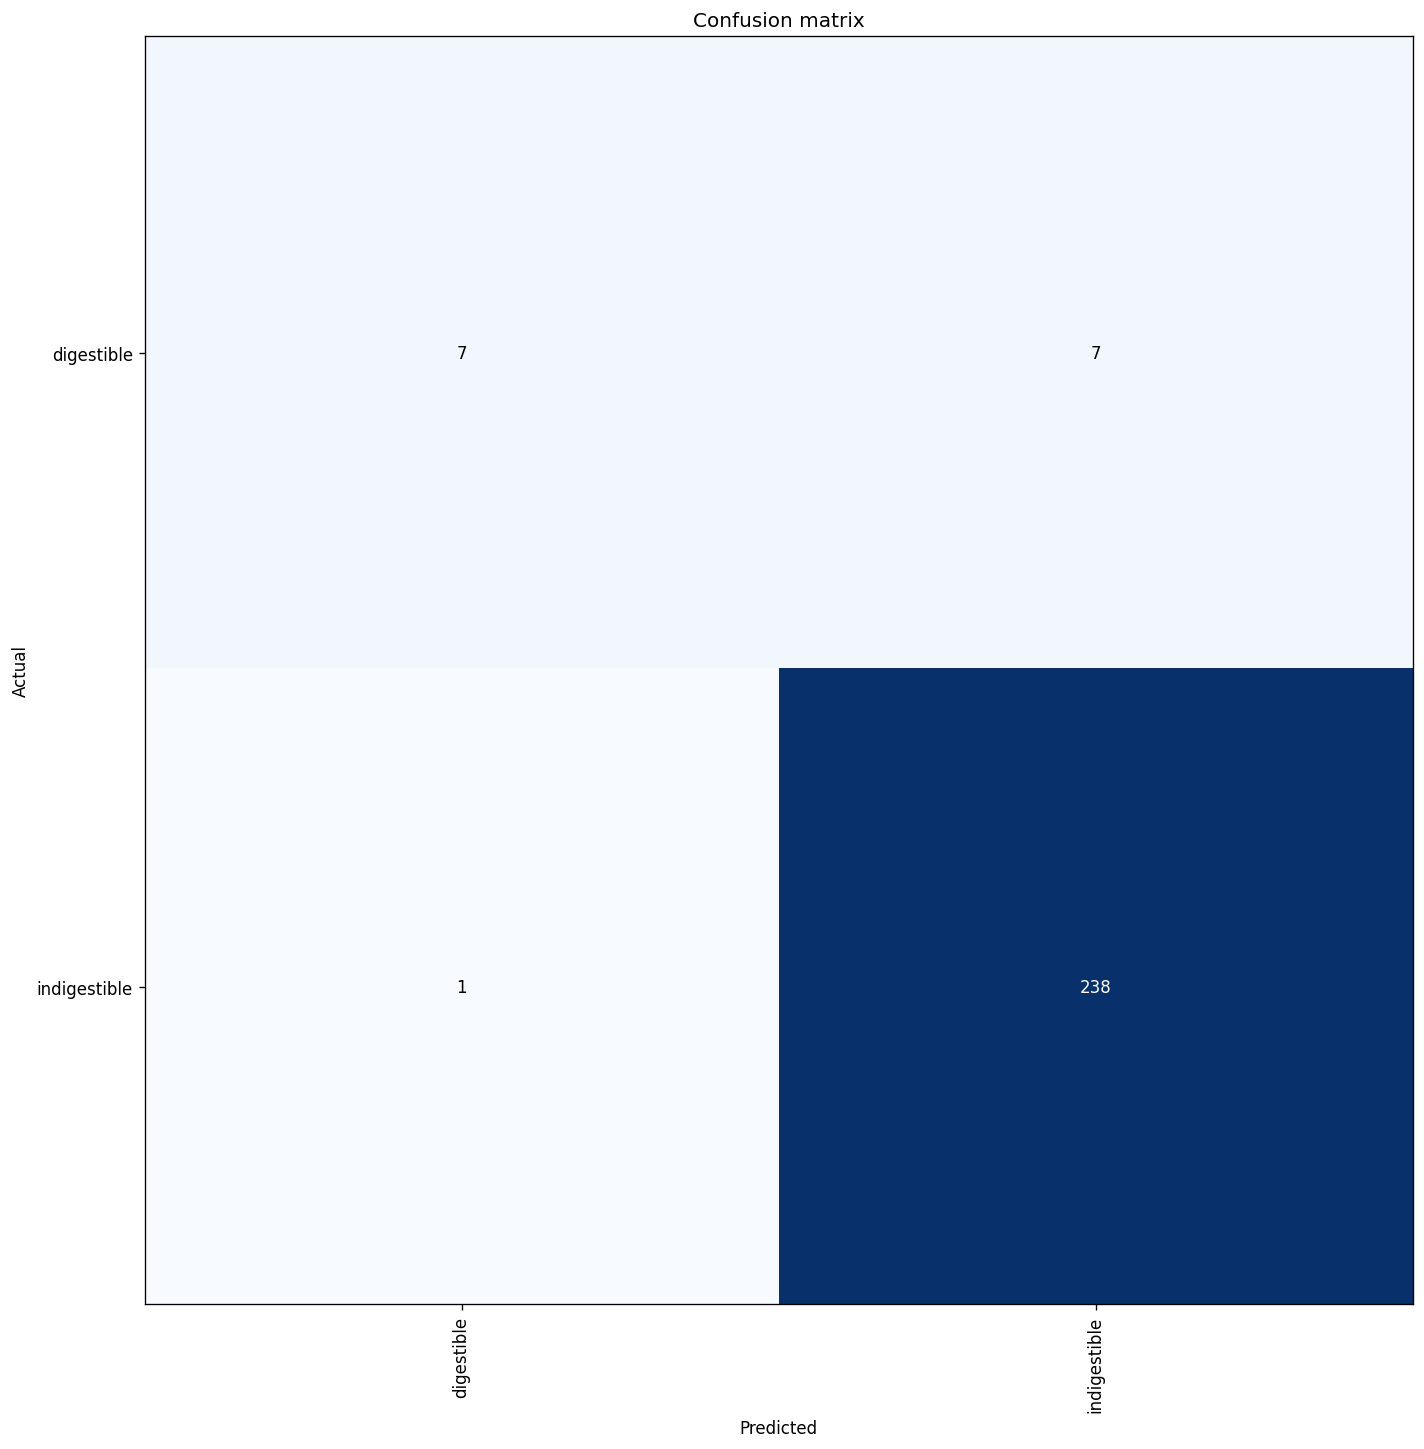

In [35]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

This model often confused plastic for glass and confused metal. The list of most confused images is below.

In [36]:
interp.most_confused(min_val=2)

[('digestible', 'indigestible', 7)]

## 4. Make new predictions on test data


In [37]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [38]:
print(preds[0].shape)
preds[0]

torch.Size([253, 2])


tensor([[3.1854e-02, 9.6815e-01],
        [5.3849e-04, 9.9946e-01],
        [7.2396e-02, 9.2760e-01],
        [1.9019e-03, 9.9810e-01],
        [7.5895e-04, 9.9924e-01],
        [3.9677e-02, 9.6032e-01],
        [5.4047e-02, 9.4595e-01],
        [1.1415e-01, 8.8585e-01],
        [6.9855e-02, 9.3015e-01],
        [1.4780e-03, 9.9852e-01],
        [2.4133e-03, 9.9759e-01],
        [1.1770e-02, 9.8823e-01],
        [4.6477e-02, 9.5352e-01],
        [2.4770e-02, 9.7523e-01],
        [5.8488e-02, 9.4151e-01],
        [8.3897e-02, 9.1610e-01],
        [1.9602e-03, 9.9804e-01],
        [3.7796e-04, 9.9962e-01],
        [1.5236e-02, 9.8476e-01],
        [4.2790e-02, 9.5721e-01],
        [3.9560e-02, 9.6044e-01],
        [5.9125e-02, 9.4088e-01],
        [1.2665e-03, 9.9873e-01],
        [7.1333e-03, 9.9287e-01],
        [1.1278e-01, 8.8722e-01],
        [1.2946e-03, 9.9871e-01],
        [3.0555e-03, 9.9694e-01],
        [2.7996e-01, 7.2004e-01],
        [8.3606e-01, 1.6394e-01],
        [3.415

In [39]:
data.classes

['digestible', 'indigestible']

Now I'm going to convert the probabilities in the tensor above to a string with one of the class names.

In [0]:
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [0]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [42]:
yhat

['indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'digestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',
 'indigestible',

These are the predicted labels of all the images! Let's check if the first image is actually glass.

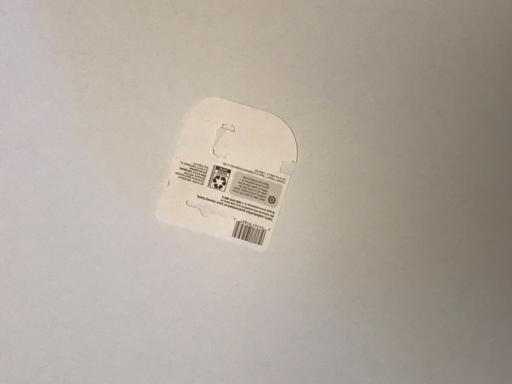

In [43]:
learn.data.test_ds[0][0]

It is!

Next, I'll get the actual labels from the test dataset.

In [0]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

A quick check.

In [45]:
## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['indigestible', 'indigestible', 'indigestible', 'indigestible', 'indigestible']
['indigestible', 'indigestible', 'digestible', 'indigestible', 'indigestible']


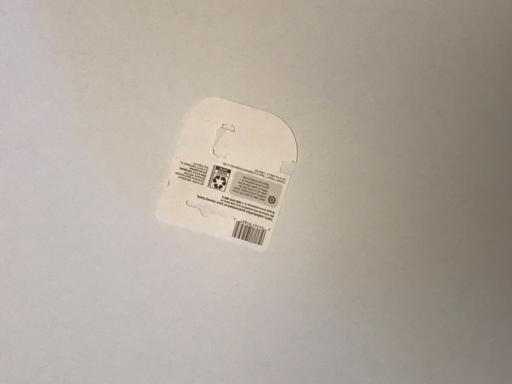

In [46]:
learn.data.test_ds[0][0]

In [47]:
cm = confusion_matrix(y,yhat)
print(cm)

[[  4  10]
 [  7 232]]


Let's try and make this matrix a little prettier.

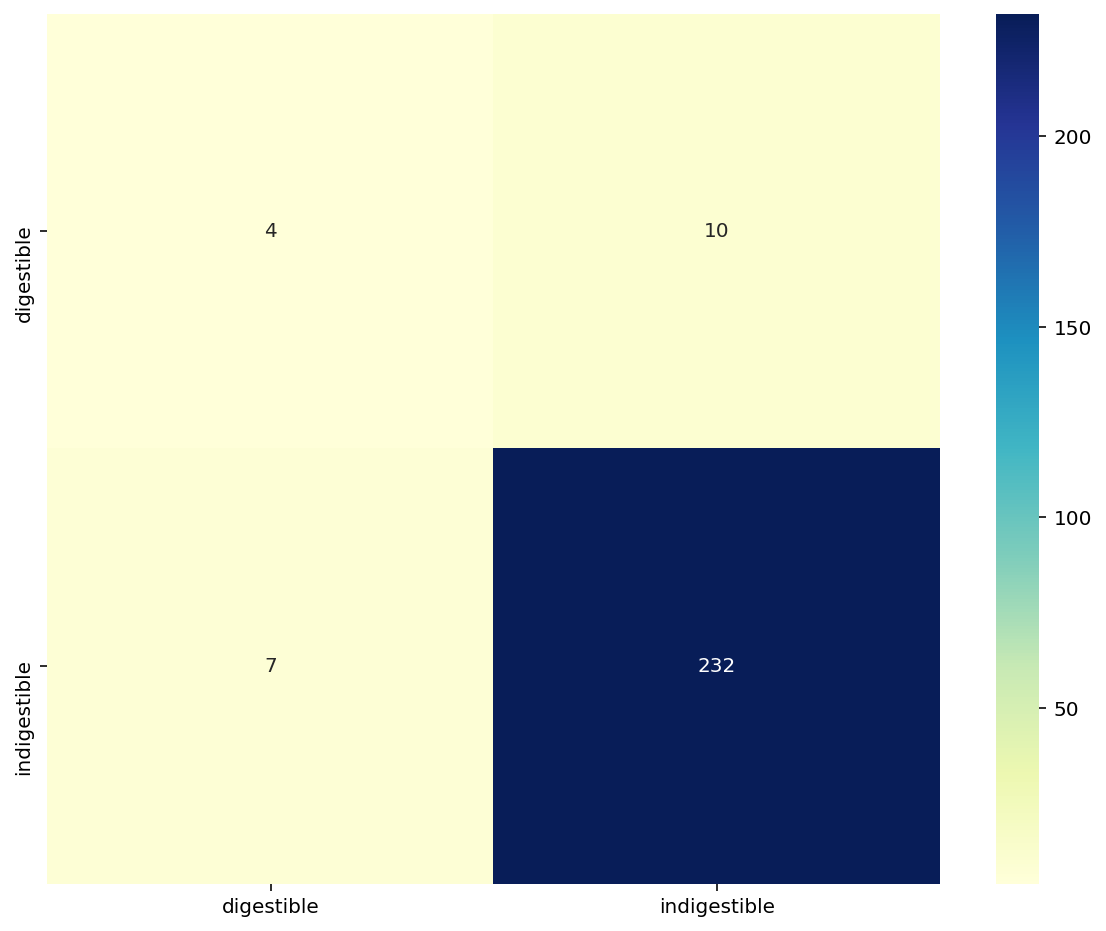

In [48]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

Again, the model seems to have confused metal for glass and plastic for glass. With more time, I'm sure further investigation could help reduce these mistakes.

In [0]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [50]:
accuracy = correct/sum(sum(cm))
accuracy

0.932806324110672

In [0]:
## delete everything when you're done to save space
shutil.rmtree("data")
shutil.rmtree('dataset-resized')

In [52]:
!ls -la

total 89700
drwxr-xr-x 1 root root     4096 Jun 14 14:15 .
drwxr-xr-x 1 root root     4096 Jun 14 13:35 ..
drwxr-xr-x 1 root root     4096 Jun 10 16:28 .config
drwxr-xr-x 3 root root     4096 Jun 14 13:38 __MACOSX
drwxr-xr-x 1 root root     4096 Jun 10 16:28 sample_data
-rw-r--r-- 1 root root    21473 Jun 14 13:39 struct
-rw-r--r-- 1 root root    37490 Jun 14 13:39 struct.pdf
-rw-r--r-- 1 root root 91764533 Jun 14 14:15 trained_model.pth


In [53]:
!date

Sun Jun 14 14:15:40 UTC 2020
